# Evaluation Metrics Part 2 - Advanced

## Learning Objectives
By the end of this notebook, you will be able to:
1. Create and interpret ROC curves
2. Understand AUC and what it measures
3. Use PR curves for imbalanced data
4. Select optimal threshold based on business needs
5. Assess probability calibration



## Introduction: Beyond Basic Metrics

In the previous notebook, we learned about accuracy, precision, recall, and F1 score. But these metrics have limitations:

**Problems with Single-Threshold Metrics:**
- They only evaluate one threshold (usually 0.5)
- They don't show how performance changes across different thresholds
- They don't account for the trade-off between precision and recall
- They don't assess the quality of probability outputs

**Advanced Metrics We'll Explore:**
- **ROC Curves:** Show how sensitivity and specificity trade off
- **AUC:** Measures overall model performance across all thresholds
- **PR Curves:** Better for imbalanced datasets
- **Threshold Optimization:** Find the best threshold for business needs
- **Calibration:** Assess how reliable our probabilities are

**Think About It:** If you're a business manager, would you rather have a model that's 90% accurate but gives you probabilities you can't trust, or one that's 85% accurate but gives reliable probabilities for decision-making?

In this notebook, we'll explore these advanced evaluation techniques that give us much deeper insights into model performance.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix, 
                           precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explore advanced evaluation metrics!")


Libraries imported successfully!
Ready to explore advanced evaluation metrics!


In [2]:
# Load and prepare the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Prepare data for modeling
features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X = df[features]
y = (df['Churn'] == 'Yes').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Dataset shape: {df.shape}")
print(f"Features: {features}")
print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Testing set: {X_test.shape[0]:,} customers")
print(f"Churn rate: {y.mean():.1%}")


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)
Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Training set: 5,634 customers
Testing set: 1,409 customers
Churn rate: 26.5%


## Section 1: ROC Curves - Understanding the Trade-off

ROC (Receiver Operating Characteristic) curves show how sensitivity and specificity trade off across different thresholds.


AUC Score: 0.811


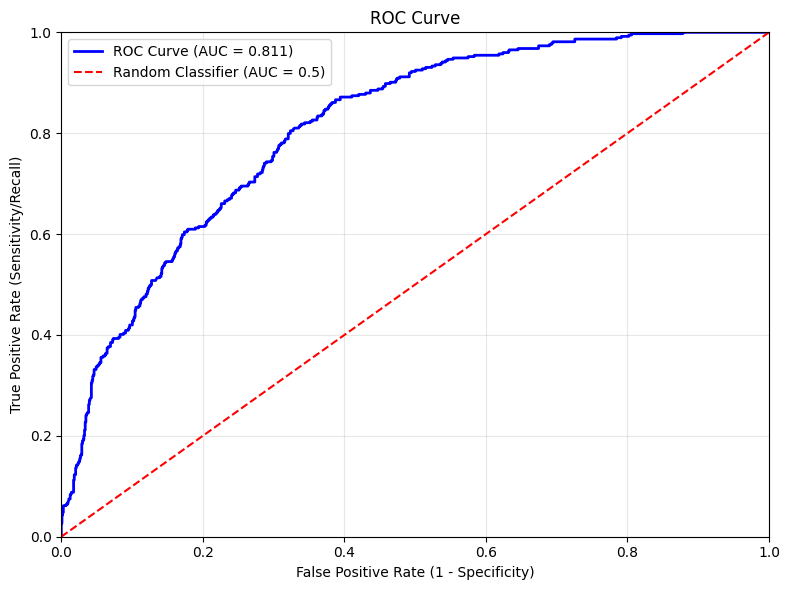

In [3]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC Score: {auc_score:.3f}")

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


### Understanding ROC Curves

**What the ROC Curve Shows:**
- **X-axis (FPR):** False Positive Rate = FP / (FP + TN) = 1 - Specificity
- **Y-axis (TPR):** True Positive Rate = TP / (TP + FN) = Sensitivity = Recall
- **Each point** represents a different threshold
- **The curve** shows how sensitivity and specificity trade off

**Key Interpretations:**
- **Top-left corner:** Perfect classifier (TPR=1, FPR=0)
- **Diagonal line:** Random classifier (no better than chance)
- **Above diagonal:** Better than random
- **Below diagonal:** Worse than random (flip predictions)

**Business Meaning:**
- **High TPR:** Catch most churners (good recall)
- **Low FPR:** Don't waste resources on non-churners (good precision)
- **Trade-off:** Can't maximize both simultaneously


## Section 2: AUC - Area Under the Curve

AUC (Area Under the ROC Curve) provides a single number to summarize overall model performance.


In [4]:
# Show AUC interpretation
print(f"Our Model AUC: {auc_score:.3f}")

# Create comparison with different AUC values
auc_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
interpretations = [
    "Random (no better than chance)",
    "Poor (barely better than random)",
    "Fair (moderate discrimination)",
    "Good (strong discrimination)",
    "Excellent (very strong discrimination)",
    "Perfect (flawless discrimination)"
]

print("\nAUC Interpretation Guide:")
print("=" * 30)
for auc, interp in zip(auc_values, interpretations):
    print(f"AUC {auc:.1f}: {interp}")

print(f"\nOur Model Performance:")
if auc_score >= 0.9:
    print(f"AUC {auc_score:.3f} = Excellent performance!")
elif auc_score >= 0.8:
    print(f"AUC {auc_score:.3f} = Good performance")
elif auc_score >= 0.7:
    print(f"AUC {auc_score:.3f} = Fair performance")
elif auc_score >= 0.6:
    print(f"AUC {auc_score:.3f} = Poor performance")
else:
    print(f"AUC {auc_score:.3f} = Very poor performance")


Our Model AUC: 0.811

AUC Interpretation Guide:
AUC 0.5: Random (no better than chance)
AUC 0.6: Poor (barely better than random)
AUC 0.7: Fair (moderate discrimination)
AUC 0.8: Good (strong discrimination)
AUC 0.9: Excellent (very strong discrimination)
AUC 1.0: Perfect (flawless discrimination)

Our Model Performance:
AUC 0.811 = Good performance


### What AUC Actually Measures

**AUC Interpretation:**
- **AUC = 0.5:** Random classifier (no discrimination ability)
- **AUC = 1.0:** Perfect classifier (flawless discrimination)
- **AUC > 0.5:** Better than random chance
- **AUC < 0.5:** Worse than random (flip predictions)

**Ranking Interpretation:**
- AUC represents the probability that a randomly chosen positive instance will have a higher score than a randomly chosen negative instance
- It measures the model's ability to rank instances correctly
- It's threshold-independent (evaluates all thresholds simultaneously)

**Business Context:**
- **High AUC:** Model can reliably distinguish between churners and non-churners
- **Low AUC:** Model struggles to separate the two classes
- **AUC is robust** to class imbalance (unlike accuracy)


## Section 3: PR Curves - Better for Imbalanced Data

Precision-Recall curves are often more informative than ROC curves for imbalanced datasets.


Average Precision (AP): 0.591


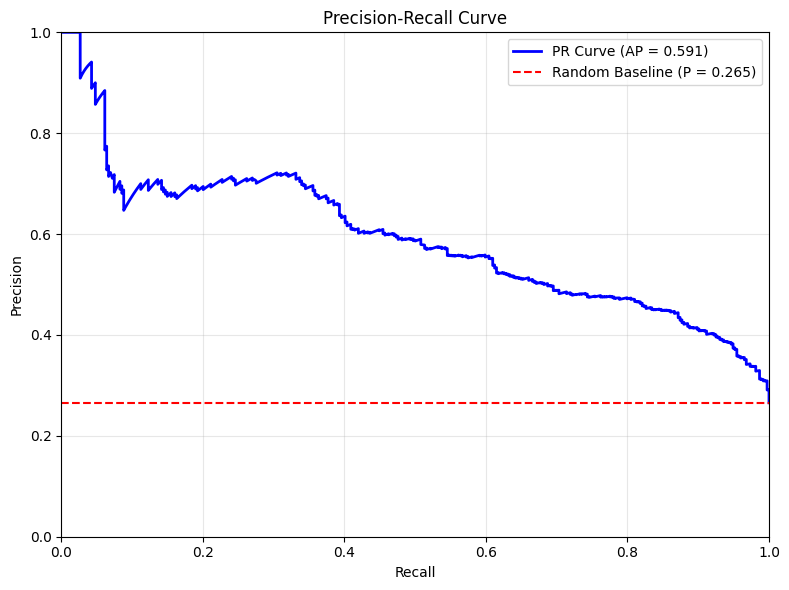

In [5]:
# Calculate PR curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Average Precision (AP): {avg_precision:.3f}")

# Create PR curve plot
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', linewidth=2, 
         label=f'PR Curve (AP = {avg_precision:.3f})')

# Add baseline (random classifier)
baseline_precision = y_test.mean()
plt.axhline(y=baseline_precision, color='red', linestyle='--', 
            label=f'Random Baseline (P = {baseline_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


### Why PR Curves Matter for Imbalanced Data

**ROC vs PR Curves:**
- **ROC curves** can be misleading with imbalanced data
- **PR curves** focus on the minority class (churn)
- **PR curves** are more sensitive to changes in the positive class

**Key Differences:**
- **ROC:** Shows TPR vs FPR (includes True Negatives)
- **PR:** Shows Precision vs Recall (focuses on positive class)
- **ROC:** Can look good even with poor precision
- **PR:** Directly shows precision-recall trade-off

**When to Use PR Curves:**
- **Imbalanced datasets** (like our churn data)
- **When precision matters** (cost of false positives)
- **When you care about the minority class**
- **Comparing models** on imbalanced data

**Business Interpretation:**
- **High precision:** Few false alarms (efficient resource use)
- **High recall:** Catch most churners (comprehensive coverage)
- **Trade-off:** Can't maximize both simultaneously


## Section 4: Threshold Selection - Business-Driven Optimization

The default threshold of 0.5 may not be optimal for your business needs. Let's find the best threshold.


In [6]:
# Calculate metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_data = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    metrics_data.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })

metrics_df = pd.DataFrame(metrics_data)

# Find optimal threshold based on F1 score
optimal_idx = metrics_df['f1'].idxmax()
optimal_threshold = metrics_df.loc[optimal_idx, 'threshold']
optimal_f1 = metrics_df.loc[optimal_idx, 'f1']

print(f"Optimal Threshold (F1): {optimal_threshold:.2f}")
print(f"Optimal F1 Score: {optimal_f1:.3f}")

# Show top 5 thresholds by F1 score
print("\nTop 5 Thresholds by F1 Score:")
print("=" * 40)
top_5 = metrics_df.nlargest(5, 'f1')[['threshold', 'precision', 'recall', 'f1']]
print(top_5.round(3))


Optimal Threshold (F1): 0.20
Optimal F1 Score: 0.586

Top 5 Thresholds by F1 Score:
   threshold  precision  recall     f1
2       0.20      0.443   0.866  0.586
3       0.25      0.475   0.762  0.585
4       0.30      0.494   0.695  0.578
6       0.40      0.556   0.602  0.578
5       0.35      0.514   0.639  0.570


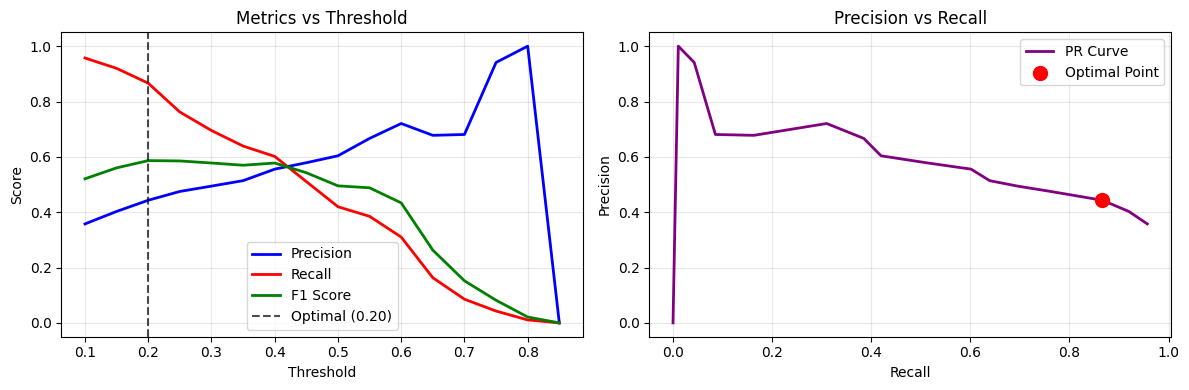

In [7]:
# Visualize threshold optimization
plt.figure(figsize=(12, 4))

# Plot 1: Precision, Recall, F1 vs Threshold
plt.subplot(1, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['precision'], 'b-', label='Precision', linewidth=2)
plt.plot(metrics_df['threshold'], metrics_df['recall'], 'r-', label='Recall', linewidth=2)
plt.plot(metrics_df['threshold'], metrics_df['f1'], 'g-', label='F1 Score', linewidth=2)
plt.axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Precision vs Recall
plt.subplot(1, 2, 2)
plt.plot(metrics_df['recall'], metrics_df['precision'], 'purple', linewidth=2, label='PR Curve')
plt.scatter(metrics_df.loc[optimal_idx, 'recall'], metrics_df.loc[optimal_idx, 'precision'], 
           color='red', s=100, label=f'Optimal Point', zorder=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Business-Driven Threshold Selection

**Different Business Scenarios:**

**Scenario 1: High Precision Needed**
- **When:** Limited resources for retention campaigns
- **Goal:** Minimize false positives (wasted effort)
- **Strategy:** Use higher threshold (e.g., 0.7-0.8)
- **Trade-off:** Lower recall (miss some churners)

**Scenario 2: High Recall Needed**
- **When:** Churn is very costly, can't afford to miss anyone
- **Goal:** Catch as many churners as possible
- **Strategy:** Use lower threshold (e.g., 0.2-0.3)
- **Trade-off:** Lower precision (more false alarms)

**Scenario 3: Balanced Approach**
- **When:** Moderate resources, moderate churn costs
- **Goal:** Balance precision and recall
- **Strategy:** Use F1-optimal threshold
- **Trade-off:** Neither precision nor recall is maximized

**Key Insight:** The "best" threshold depends on your business priorities and costs!


## Section 5: Calibration - Are Our Probabilities Reliable?

Calibration assesses whether our probability outputs are trustworthy for decision-making.


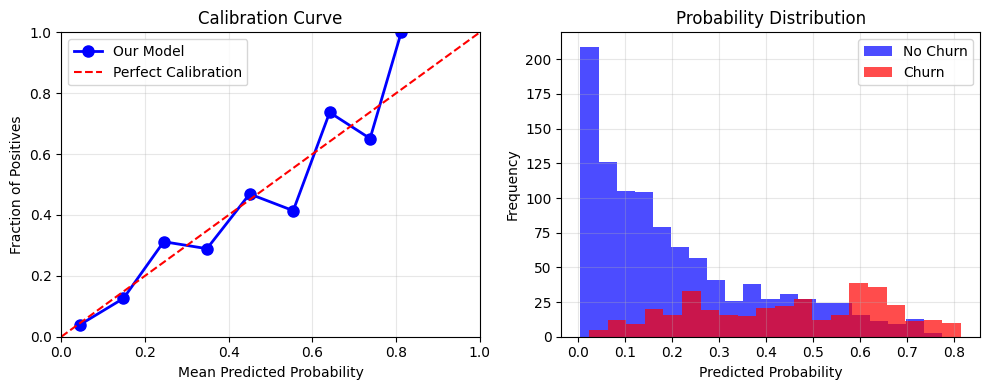

In [8]:
# Create calibration plot
from sklearn.calibration import calibration_curve

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10
)

# Create calibration plot
plt.figure(figsize=(10, 4))

# Plot 1: Calibration curve
plt.subplot(1, 2, 1)
plt.plot(mean_predicted_value, fraction_of_positives, 'bo-', linewidth=2, markersize=8, label='Our Model')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Plot 2: Probability distribution
plt.subplot(1, 2, 2)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Churn', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Churn', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Understanding Calibration

**What Calibration Means:**
- **Well-calibrated:** When we predict 70% probability, about 70% of those cases actually occur
- **Poorly calibrated:** When we predict 70% probability, but only 50% actually occur
- **Perfect calibration:** Red dashed line (diagonal)

**Why Calibration Matters:**
- **Business decisions** rely on probability estimates
- **Risk assessment** needs trustworthy probabilities
- **Resource allocation** depends on accurate risk estimates
- **Stakeholder communication** requires reliable numbers

**Interpreting the Plots:**
- **Left plot:** Calibration curve - how close to diagonal?
- **Right plot:** Probability distribution - are probabilities well-separated?
- **Good model:** Close to diagonal + good separation between classes

**Business Impact:**
- **Well-calibrated model:** Can trust probabilities for decision-making
- **Poorly calibrated model:** Probabilities are misleading
- **Calibration can be improved** with techniques like Platt scaling


## Summary: Advanced Evaluation Concepts

This notebook explored advanced evaluation techniques that provide deeper insights into model performance:

### What We Learned

1. **ROC Curves:** Show sensitivity-specificity trade-offs across all thresholds
2. **AUC:** Single metric measuring overall discrimination ability
3. **PR Curves:** Better for imbalanced data, focus on precision-recall trade-off
4. **Threshold Optimization:** Find optimal threshold based on business needs
5. **Calibration:** Assess reliability of probability outputs

### Key Takeaways

- **Single metrics are insufficient** - need multiple perspectives
- **ROC curves** are good for balanced data, **PR curves** for imbalanced data
- **AUC** measures ranking ability, not just classification performance
- **Threshold selection** should be driven by business priorities
- **Calibration** ensures probabilities are trustworthy for decision-making
- **Advanced metrics** provide actionable insights for model improvement
